In [ ]:
# install required packages
!pip install datasets
!pip install re
!pip install collections
!pip install matplotlib
!pip install nltk

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 22.2 MB/s  0:00:00

   ---------------------------------------- 0/3 [regex]
   ---------------------------------------- 0/3 [regex]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   -------------------------- ------------- 2/3 [nltk]
   ------

In [ ]:
# Imports 
from datasets import load_dataset
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import math

In [95]:


# Source: Rotten Tomatoes (movie reviews)



rt = load_dataset("rotten_tomatoes")   # splits: train/validation/test

# Target: Amazon Polarity (product reviews)
amz = load_dataset("amazon_polarity")  # splits: train/test

# stopwords from nltk
nltk.download("stopwords")

print(rt)
print(amz)

amz["train"][6]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oliv9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'label': 0,
 'title': 'Buyer beware',
 'content': 'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'}

In [ ]:
# Basic text cleaning + tokenization simple, consistent across domains
STOPWORDS = set(stopwords.words("english"))

# Normalization
def normalize(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s']", " ", text)   
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Tokenization removing stopwords
def tokenize(text: str):
    text = normalize(text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens
# Text length (in tokens)
def text_length(tokens):
    return len(tokens)


In [39]:
# Sample from Amazon to match Rotten Tomatoes train size
AMZ_SAMPLE_N = len(rt["train"])
amz_train_sample = amz["train"].shuffle(seed=42).select(range(AMZ_SAMPLE_N))

print("RT train size:", len(rt["train"]))
print("AMZ train sample size:", len(amz_train_sample))


RT train size: 8530
AMZ train sample size: 8530


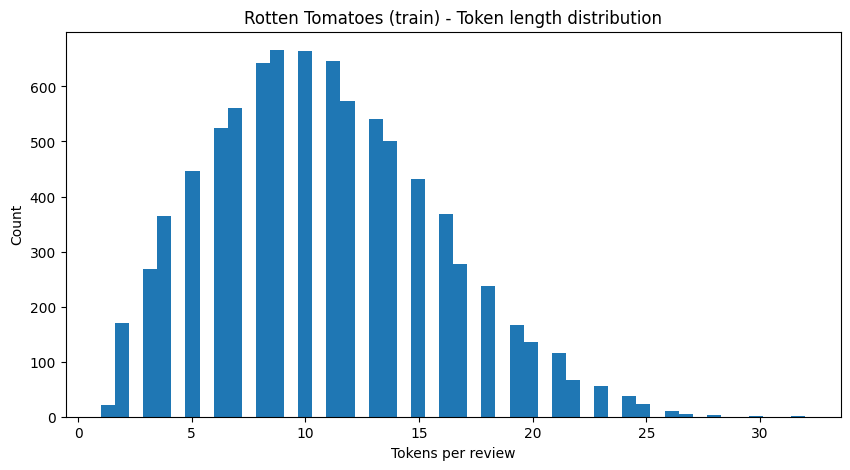

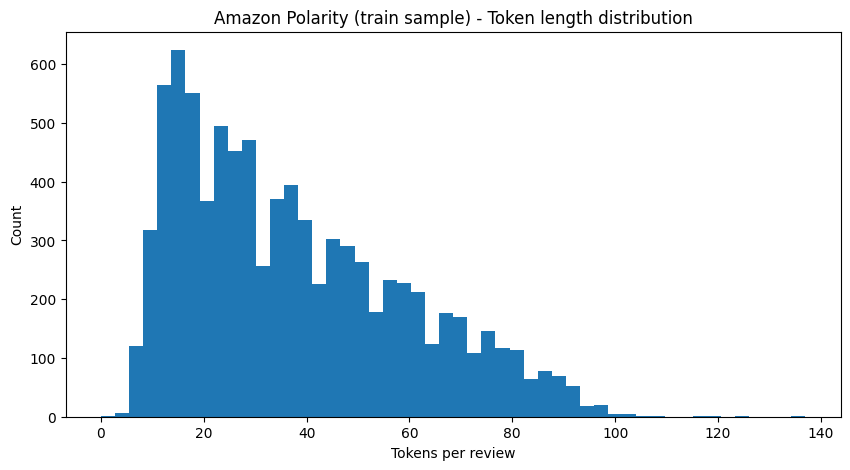

In [45]:
# Helper: compute token counts + lengths for a dataset split + plot
def corpus_stats(ds, text_col="text", label_col="label", max_docs=None):
    # ds: a HF Dataset object
    if max_docs is not None:
        ds = ds.select(range(min(max_docs, len(ds))))

    lengths = []
    counts_all = Counter()
    counts_by_label = {0: Counter(), 1: Counter()}

    for ex in ds:
        toks = tokenize(ex[text_col])
        lengths.append(len(toks))
        counts_all.update(toks)
        if label_col in ex:
            counts_by_label[ex[label_col]].update(toks)

    return lengths, counts_all, counts_by_label

# Rotten Tomatoes stats
rt_lengths, rt_counts, rt_counts_by_label = corpus_stats(rt["train"], text_col="text", label_col="label")

# Amazon stats (sample)
amz_lengths, amz_counts, amz_counts_by_label = corpus_stats(amz_train_sample, text_col="content", label_col="label")

# Plots: text length distributions
plt.figure(figsize=(10, 5))
plt.hist(rt_lengths, bins=50)
plt.title("Rotten Tomatoes (train) - Token length distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(amz_lengths, bins=50)
plt.title("Amazon Polarity (train sample) - Token length distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

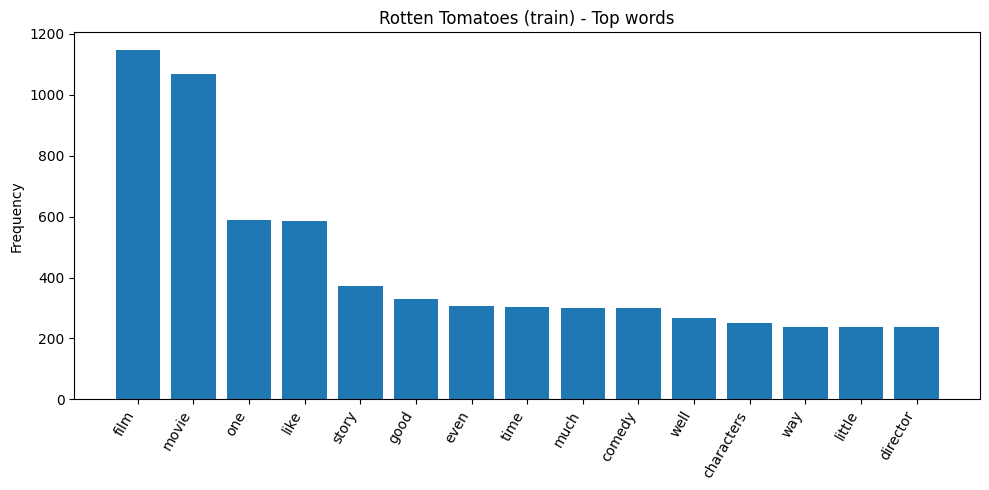

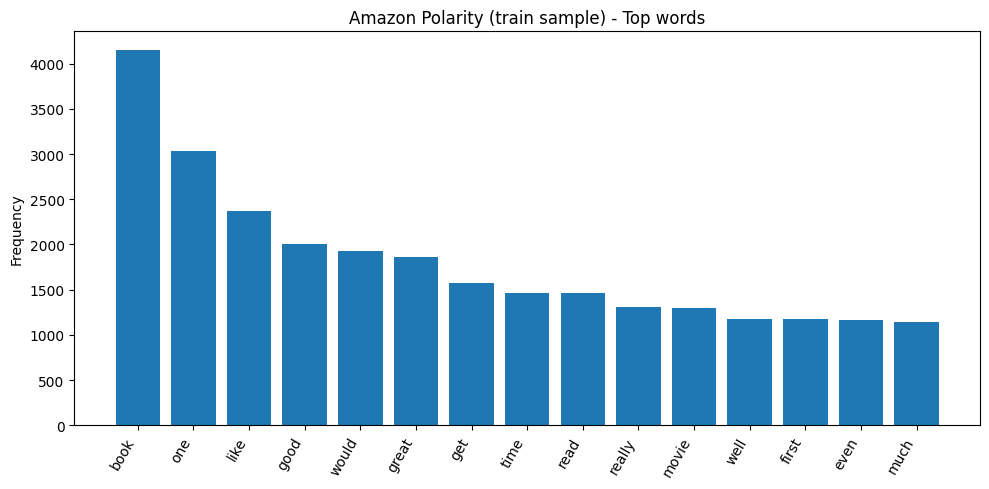

In [44]:
def plot_top_words(counter: Counter, title: str, n=30):
    common = counter.most_common(n)
    words = [w for w, _ in common]
    freqs = [c for _, c in common]

    plt.figure(figsize=(10, 5))
    plt.bar(words, freqs)
    plt.title(title)
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_words(rt_counts, "Rotten Tomatoes (train) - Top words", n=15)
plot_top_words(amz_counts, "Amazon Polarity (train sample) - Top words", n=15)

In [ ]:
# frequent words in one domain but not the other
TOP_K = 20
rt_top = set([w for w, _ in rt_counts.most_common(TOP_K)])
amz_top = set([w for w, _ in amz_counts.most_common(TOP_K)])

only_rt = sorted(list(rt_top - amz_top))
only_amz = sorted(list(amz_top - rt_top))
overlap = sorted(list(rt_top & amz_top))

print(f"Top-{TOP_K} overlap:", len(overlap))
print(f"Only RT in top-{TOP_K}:", len(only_rt))
print(f"Only AMZ in top-{TOP_K}:", len(only_amz))

print("\nExamples only in Rotten Tomatoes:", only_rt[:15])
print("\nExamples only in Amazon:", only_amz[:15])
print("\nExamples overlap:", overlap[:15])

Top-20 overlap: 8
Only RT in top-20: 12
Only AMZ in top-20: 12

Examples only in Rotten Tomatoes: ['characters', 'comedy', 'director', 'enough', 'film', 'funny', 'little', 'make', 'makes', 'never', 'story', 'way']

Examples only in Amazon: ['also', 'better', 'book', 'buy', 'cd', 'first', 'get', 'great', 'love', 'read', 'really', 'would']

Examples overlap: ['even', 'good', 'like', 'movie', 'much', 'one', 'time', 'well']


In [76]:
TOP_K = 200
rt_top = set([w for w, _ in rt_counts.most_common(TOP_K)])
amz_top = set([w for w, _ in amz_counts.most_common(TOP_K)])

only_rt = sorted(list(rt_top - amz_top))
only_amz = sorted(list(amz_top - rt_top))
overlap = sorted(list(rt_top & amz_top))
# Concept drift indicator: words whose pos/neg association flips across domains
# We compute a simple log-odds style score: log((c_pos+1)/(c_neg+1))


def association_score(counts_by_label, word):
    c_pos = counts_by_label[1][word]
    c_neg = counts_by_label[0][word]
    return math.log((c_pos + 1) / (c_neg + 1))

# Candidate words: shared frequent words after filtering
CANDIDATES = list(overlap)  # overlap among top-K already
flips = []

for w in CANDIDATES:
    s_rt = association_score(rt_counts_by_label, w)
    s_amz = association_score(amz_counts_by_label, w)

    # flip when sign differs (positive association vs negative association)
    if (s_rt > 0 and s_amz < 0) or (s_rt < 0 and s_amz > 0):
        flips.append((w, s_rt, s_amz, abs(s_rt - s_amz)))

flips_sorted = sorted(flips, key=lambda x: x[3], reverse=True)[:16]

df_flips = pd.DataFrame(flips_sorted, columns=["word", "score_rt", "score_amz", "diff"])
display(df_flips)


,word,score_rt,score_amz,diff
0,look,0.752571,-0.224260,0.976831
1,things,-0.784955,0.160840,0.945794
2,every,-0.526093,0.319287,0.845381
3,anyone,-0.510826,0.307305,0.818131
4,part,0.712950,-0.088193,0.801143
5,work,0.354172,-0.394654,0.748826
6,give,0.393043,-0.303013,0.696056
7,worth,0.602996,-0.063988,0.666984
8,two,0.228534,-0.347724,0.576259
9,long,-0.521875,0.052770,0.574645
